In [1]:
## Librerías
import numpy as np
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import keras
from sklearn.model_selection import train_test_split
import matplotlib
import os

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import umap
from sklearn.preprocessing import StandardScaler

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

from keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2023-08-22 00:20:05.573006: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-22 00:20:05.766820: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/dist-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mo

2.12.0


/usr/local/lib/python3.8/dist-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


In [2]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.6):
    # Load the original image
    nsize = 128
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img.resize((nsize,nsize)))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.colormaps['jet']
    

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    #superimposed_img.save(cam_path)
    
    # Display Grad CAM
    #display(Image(cam_path))
    
    return superimposed_img, jet_heatmap * alpha

In [3]:
## Uso de GPU
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

## Average CAM per class

In [3]:
## Seleccionar la clase [CuNi1, CuNi2, CuNi3]
clss = "CuNi3"

# Recorrer la imágen
img_n = 0

## Mostrar dimension N
dim = 87

## Recorrer cada una de las imágenes
route = 'results_vae_gradcam/'+clss+'/*' #"/*.npy"   

path = glob.glob(route) 

#Lista para guardar el nombre de las imágenes en orden
img_names= []

for img in path:     
    img_name = img.split('/')[-1]
    img_names.append(img_name)     


# Ruta de .npy
route_npys = 'results_vae_gradcam/'+clss+'/'+img_names[img_n]+"/*.npy"

path_npy = glob.glob(route_npys)

# Ruta de cams
route_cams = 'results_vae_gradcam/'+clss+'/'+img_name+'/'+img_names[img_n]+'/*.jpg'

path_cams = glob.glob(route_cams)

#imagen original
route_img = 'recortadas1/'+clss+'/'+img_names[img_n]+'.jpg'

## Recorrer npys y guardarlos en una lista
all_npys = []
for n in range(len(path_npy)):
    new_route = 'results_vae_gradcam/'+clss+'/'+img_names[img_n]+'/'+img_names[img_n]+'_'+str(n)+"_heatmap.npy"
    npy_data = np.load(new_route)
    all_npys.append(npy_data)
print(np.shape(all_npys))

### Graficar GRADCAM

Dimensión de la imágen de entrada:  (1, 128, 128, 1)


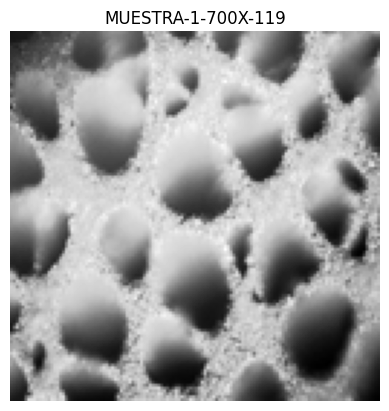

In [175]:
## Leer la imagen
img0 = tf.keras.preprocessing.image.load_img(route_img,color_mode='grayscale') 

# Array y redimensionar
img0 = tf.keras.preprocessing.image.img_to_array(img0.resize((128,128)))

# expand dims 
img = np.expand_dims(img0, axis=0)

print("Dimensión de la imágen de entrada: ",np.shape(img))
plt.imshow(img[0],cmap='gray')
plt.title(img_names[img_n])
plt.axis('off')
plt.show()

In [176]:
print(np.shape(all_npys))
plt.imshow(all_npys[0])
plt.show()

(128, 16, 16)


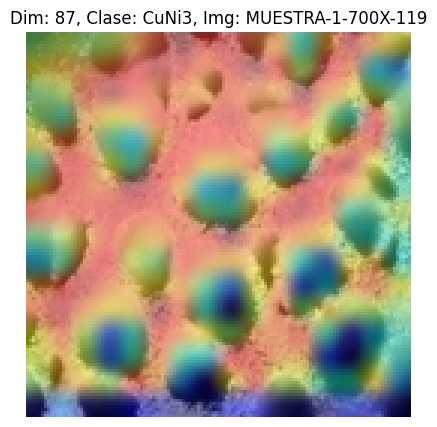

In [177]:
gap_maps = []

merged, fit_heatmap = save_and_display_gradcam(route_img, all_npys[dim])
    
gap_maps.append(fit_heatmap)

fig, ax1 = plt.subplots(1, figsize=(15, 5))  
ax1.imshow(merged); ax1.axis('off'); ax1.set_title('Dim: '+str(dim)+', Clase: '+clss+', Img: '+img_names[img_n])
sliceName = os.path.join(*route_img.split('/')[1:])
#plt.savefig('results_vae_gradcam'+'/'+str(nx))
plt.show()

In [178]:
X_gap_mean = np.apply_over_axes(np.mean, np.array(all_npys), [0])
X_gap_sum = np.apply_over_axes(np.sum, np.array(all_npys), [0])
print(np.shape(X_gap_mean),np.shape(X_gap_sum))

(1, 16, 16) (1, 16, 16)


In [179]:
plt.imshow(X_gap_mean[0])
plt.axis('Off')
plt.show()

In [180]:
gap_maps = []

merged, fit_heatmap = save_and_display_gradcam(route_img, X_gap_mean[0])
    
gap_maps.append(fit_heatmap)

fig, ax1 = plt.subplots(1, figsize=(15, 5))  
ax1.imshow(merged); ax1.axis('off'); ax1.set_title('Mapa promedio')
sliceName = os.path.join(*route_img.split('/')[1:])
plt.tight_layout()
#plt.savefig('results_vae_gradcam'+'/'+str(nx))
plt.show()

In [181]:
plt.imshow(X_gap_sum[0])
print(np.min(X_gap_sum[0]),np.max(X_gap_sum[0]))
plt.axis('Off')
plt.show()

19.57305 47.769978


In [182]:
gap_maps = []

merged, fit_heatmap = save_and_display_gradcam(route_img, X_gap_sum[0])
    
gap_maps.append(fit_heatmap)

fig, ax1 = plt.subplots(1, figsize=(15, 5))  
ax1.imshow(merged); ax1.axis('off'); ax1.set_title('Mapa Suma')
sliceName = os.path.join(*route_img.split('/')[1:])
plt.tight_layout()
#plt.savefig('results_vae_gradcam'+'/'+str(nx))
plt.show()

## Matriz con mapas de activación


In [183]:
## Dimesiones de la imágen:
rows = 13
cols = 10


## Recorrer filas
fig = plt.figure("Mapas de activación Grad-CAM para la clase "+str(clss),figsize=(8,12))
n = 0
for j in range(rows):
    for i in range(cols):
        n += 1        
        #print(n)
        if n >= len(all_npys):
            ax = fig.add_subplot(rows, cols, n)
            ax.set_title('')
            #ax.imshow(np.zeros([16,16]))
            ax.axis('off')   
        else:
            ax = fig.add_subplot(rows, cols, n)
            merged, fit_heatmap = save_and_display_gradcam(route_img, all_npys[n-1])
            ax.set_title('dim: '+str(n-1),fontsize=8)
            ax.imshow(merged)
            ax.axis('off')

plt.tight_layout()
plt.show()

16


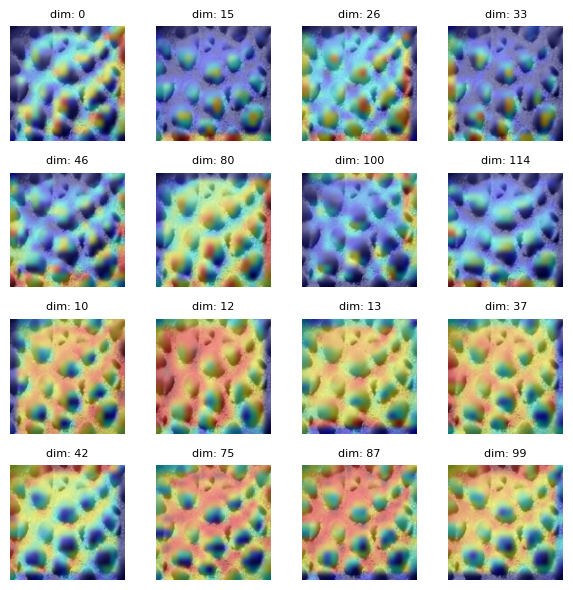

In [184]:
## Dimesiones de la imágen:
rows = 4
cols = 4

ns = [0,15,26,33,46,80,100,114,10,12,13,37,42,75,87,99]
print(len(ns))
## Recorrer filas
fig = plt.figure("Mapas de activación Grad-CAM para la clase "+str(clss),figsize=(6,6))
n = 0
for j in range(rows):
    for i in range(cols):
        n += 1        
        #print(n)
        if n >= len(ns)+1:
            ax = fig.add_subplot(rows, cols, n)
            ax.set_title('')
            #ax.imshow(np.zeros([16,16]))
            ax.axis('off')   
        else:
            ax = fig.add_subplot(rows, cols, n)
            merged, fit_heatmap = save_and_display_gradcam(route_img, all_npys[ns[n-1]])
            ax.set_title('dim: '+str(ns[n-1]),fontsize=8)
            ax.imshow(merged)
            ax.axis('off')

plt.tight_layout()
plt.show()